# Random Forest por Píxel para Clasificación de Cultivos

En este notebook desarrollaremos un modelo de Random Forest por píxel utilizando los datos generados por el script 9 (`9_NDVI_con_recortes.tif`). Este raster contiene:

- **Banda 1**: Categorías de invierno (INTA)
- **Banda 2**: Categorías de verano (INTA)
- **Bandas 3+**: Estadísticas NDVI temporales (mediana, mínimo, máximo, desviación estándar) y series temporales de NDVI

El objetivo es entrenar un clasificador que pueda predecir las categorías de cultivos a partir de las características espectrales y fenológicas derivadas del NDVI.

## Consideraciones Espaciales

Es fundamental tener en cuenta que cuando trabajamos con datos espaciales, los píxeles vecinos suelen estar correlacionados espacialmente. Si entrenamos con píxeles que son vecinos de los píxeles de test, el modelo puede "hacer trampa" al aprender patrones espaciales locales en lugar de patrones generalizables.

Para manejar esta complicación típica de los modelos espaciales, implementaremos métodos modernos de validación espacial que aseguren que:

1. Los píxeles de entrenamiento no sean vecinos espaciales de los píxeles de test
2. Se mantenga la independencia espacial entre los conjuntos de entrenamiento y validación
3. Las métricas de evaluación reflejen la capacidad real de generalización del modelo


In [5]:
import numpy as np
import pandas as pd
import rasterio
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import joblib

# ============================================================================
# CONFIGURACION DE PATHS
# ============================================================================

# Directorio base del proyecto (el notebook está en scripts/, subimos un nivel)
PROJECT_ROOT = os.path.join("..")
DATA_PROC_DIR = os.path.join(PROJECT_ROOT, "data", "proc")

# Archivo de entrada generado por el script 9
RASTER_PATH = os.path.join(DATA_PROC_DIR, "11_NDVI_inta_verano.tif")

# Convertir a ruta absoluta para verificación
RASTER_PATH_ABS = os.path.abspath(RASTER_PATH)

print(f"Raster de entrada (relativo): {RASTER_PATH}")
print(f"Raster de entrada (absoluto): {RASTER_PATH_ABS}")
print(f"Archivo existe: {os.path.exists(RASTER_PATH)}")

# ============================================================================
# CARGAR MODELO Y VARIABLES PARA VISUALIZACIONES
# ============================================================================

# Cargar modelo guardado
modelo_path = os.path.join(DATA_PROC_DIR, "11_rf_model_50_estimators.pkl")
if os.path.exists(modelo_path):
    print(f"\nCargando modelo desde: {modelo_path}")
    rf_model_50 = joblib.load(modelo_path)
    print("[OK] Modelo cargado exitosamente")
else:
    print(f"\n[ADVERTENCIA] Modelo no encontrado en: {modelo_path}")
    print("Ejecuta primero las celdas de entrenamiento del modelo")

# Cargar datos necesarios para visualizaciones (si no existen)
if 'y_clean' not in locals() or 'X_clean' not in locals() or 'indices_clean' not in locals():
    print("\nCargando datos del raster para visualizaciones...")
    
    with rasterio.open(RASTER_PATH) as src:
        # Leer banda 1: categorías INTA verano
        categorias_inta = src.read(1)
        
        # Leer bandas 2-12: features (estadísticas + series temporales)
        features_list = []
        for i in range(2, 13):
            banda = src.read(i).astype(np.float32)
            if src.nodata is not None:
                banda[banda == src.nodata] = np.nan
            features_list.append(banda)
        
        # Apilar features: shape (11, height, width)
        X_all = np.stack(features_list, axis=0)
        
        # Obtener metadata
        height, width = categorias_inta.shape
        transform = src.transform
        crs = src.crs
    
    # Reshape para tener (n_pixels, n_features)
    n_pixels = height * width
    X_all = X_all.reshape(X_all.shape[0], -1).T  # Shape: (n_pixels, n_features)
    categorias_inta_flat = categorias_inta.flatten()
    
    # Definir mapeo de categorías
    cultivos_agricolas = [10, 11, 12, 18, 26]
    barbecho = [21]
    no_agricola = [22, 255]
    
    # Crear variable objetivo agrupada
    y_agrupado = np.full_like(categorias_inta_flat, -1, dtype=np.int32)
    
    for cat_val in cultivos_agricolas:
        y_agrupado[categorias_inta_flat == cat_val] = 0  # CULTIVO AGRÍCOLA
    
    y_agrupado[categorias_inta_flat == 21] = 1  # BARBECHO
    
    for cat_val in no_agricola:
        y_agrupado[categorias_inta_flat == cat_val] = 2  # NO AGRÍCOLA
    
    # Filtrar píxeles válidos
    mask_valido = y_agrupado >= 0
    X_valido = X_all[mask_valido]
    y_valido = y_agrupado[mask_valido]
    
    # Filtrar píxeles con NaN en features
    mask_sin_nan = ~np.any(np.isnan(X_valido), axis=1)
    X_clean = X_valido[mask_sin_nan]
    y_clean = y_valido[mask_sin_nan]
    
    # Obtener índices de píxeles válidos
    indices_validos = np.where(mask_valido)[0]
    indices_clean = indices_validos[mask_sin_nan]
    
    # Nombres de clases
    nombres_clases = ['CULTIVO AGRÍCOLA', 'BARBECHO', 'NO AGRÍCOLA']
    
    print(f"[OK] Datos cargados: {len(X_clean):,} píxeles válidos")
    print(f"Dimensiones espaciales: {height} x {width}")
else:
    print("\n[OK] Variables y_clean, X_clean e indices_clean ya existen")

# Generar predicciones y mapas (si no existen)
if 'y_pred_all' not in locals() and 'rf_model_50' in locals():
    print("\nGenerando predicciones para todos los píxeles válidos...")
    y_pred_all = rf_model_50.predict(X_clean)
    print(f"[OK] Predicciones generadas: {len(y_pred_all):,} píxeles")
elif 'y_pred_all' in locals():
    print("\n[OK] Variable y_pred_all ya existe")
else:
    print("\n[ADVERTENCIA] No se puede generar y_pred_all: modelo no cargado")

# Generar mapas 2D (si no existen)
if ('mapa_realidad' not in locals() or 'mapa_prediccion' not in locals()) and 'y_clean' in locals() and 'y_pred_all' in locals():
    print("\nGenerando mapas 2D de realidad y predicción...")
    mapa_realidad = np.full((height, width), -1, dtype=np.int32)
    mapa_prediccion = np.full((height, width), -1, dtype=np.int32)
    
    mapa_realidad.flat[indices_clean] = y_clean
    mapa_prediccion.flat[indices_clean] = y_pred_all
    
    print("[OK] Mapas 2D generados")
elif 'mapa_realidad' in locals() and 'mapa_prediccion' in locals():
    print("\n[OK] Mapas mapa_realidad y mapa_prediccion ya existen")
else:
    print("\n[ADVERTENCIA] No se pueden generar mapas: faltan variables necesarias")

print("\n" + "=" * 80)
print("[OK] Setup completo para visualizaciones")
print("=" * 80)

Raster de entrada (relativo): ..\data\proc\11_NDVI_inta_verano.tif
Raster de entrada (absoluto): e:\ade_modelo_agricola\data\proc\11_NDVI_inta_verano.tif
Archivo existe: True

Cargando modelo desde: ..\data\proc\11_rf_model_50_estimators.pkl
[OK] Modelo cargado exitosamente

[OK] Variables y_clean, X_clean e indices_clean ya existen

Generando predicciones para todos los píxeles válidos...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    5.9s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    9.2s finished


[OK] Predicciones generadas: 8,104,712 píxeles

Generando mapas 2D de realidad y predicción...
[OK] Mapas 2D generados

[OK] Setup completo para visualizaciones


## Elección de estación y agrupación de categorías

En el notebook del EDA inicial vimos que nos conviene entrenar un modelo para invierno y otro para verano. Arrancamos con el de verano. Las categorías del INTA eran un tanto heterogéneas, así que vamos a agruparlas en tres clases principales:

- **CULTIVO AGRÍCOLA**: Maíz (10), Soja (11), Girasol (12), Sorgo (18), Papa (26)
- **BARBECHO**: Barbecho (21)
- **NO AGRÍCOLA**: No agrícola (22) y 255 (nodata/máscara)

Esta agrupación simplifica el problema de clasificación y agrupa cultivos con características fenológicas similares.

## Decisiones de Modelado

### 1. Variables Predictoras (Features)

Utilizaremos las siguientes bandas del raster `11_NDVI_inta_verano.tif`:
- **Bandas 2-5**: Estadísticas NDVI (mediana, mínimo, máximo, desviación estándar) calculadas sobre los meses desde diciembre 2023
- **Bandas 6-12**: Series temporales NDVI (7 meses: dic-2023 a jun-2024)

**Total: 11 features** que capturan tanto la variabilidad temporal como las estadísticas resumen del NDVI.

### 2. Variable Objetivo

Clasificación multiclase en 3 categorías:
- **0**: CULTIVO AGRÍCOLA
- **1**: BARBECHO  
- **2**: NO AGRÍCOLA

### 3. Validación Espacial

Para evitar la autocorrelación espacial, implementaremos una estrategia de **validación por bloques espaciales**:

- Dividiremos el área en bloques espaciales (grid)
- Los bloques de entrenamiento y test estarán separados espacialmente
- Esto asegura que píxeles vecinos no estén en conjuntos diferentes

### 4. Algoritmo: Random Forest

**Hiperparámetros seleccionados**:
- `n_estimators`: Se optimizará mediante análisis de OOB error (rango 10-200)
- `max_depth=20`: Limita la profundidad de los árboles para evitar sobreajuste
- `min_samples_split=5`: Evita sobreajuste en hojas pequeñas
- `min_samples_leaf=2`: Controla la complejidad de las hojas
- `oob_score=True`: Cuando se entrena un Random Forest, cada árbol es entrenado con una muestra diferente de los datos originales mediante bootstrapping. Los datos que no fueron seleccionados para entrenar un árbol específico se denominan muestras "Out-of-Bag" (OOB). Al habilitar `oob_score=True`, el modelo devuelve estas muestras OOB que usa para evaluar el desempeño de la clasificación en cada árbol, promediando luego los resultados en todos los árboles sin ver la data de test. Este es el score que vamos a usar para comparar distintos n_estimators y elegir el que "quiebra" el grafico

In [6]:
# Cargar datos del raster
print("=" * 80)
print("CARGANDO DATOS")
print("=" * 80)

with rasterio.open(RASTER_PATH) as src:
    # Leer banda 1: categorías INTA verano
    categorias_inta = src.read(1)
    
    # Leer bandas 2-12: features (estadísticas + series temporales)
    features_list = []
    for i in range(2, 13):
        banda = src.read(i).astype(np.float32)
        if src.nodata is not None:
            banda[banda == src.nodata] = np.nan
        features_list.append(banda)
    
    # Apilar features: shape (11, height, width)
    X_all = np.stack(features_list, axis=0)
    
    # Obtener metadata
    height, width = categorias_inta.shape
    transform = src.transform
    crs = src.crs
    
    print(f"\nDimensiones del raster: {height} x {width}")
    print(f"Numero de features: {X_all.shape[0]}")
    print(f"CRS: {crs}")

# Reshape para tener (n_pixels, n_features)
n_pixels = height * width
X_all = X_all.reshape(X_all.shape[0], -1).T  # Shape: (n_pixels, n_features)
categorias_inta_flat = categorias_inta.flatten()

print(f"\nTotal de píxeles: {n_pixels:,}")
print(f"Shape de X: {X_all.shape}")
print(f"Shape de y: {categorias_inta_flat.shape}")

# Definir mapeo de categorías
# CULTIVO AGRÍCOLA: 10 (Maíz), 11 (Soja), 12 (Girasol), 18 (Sorgo), 26 (Papa)
# BARBECHO: 21
# NO AGRÍCOLA: 22 (No agrícola), 255 (nodata)

cultivos_agricolas = [10, 11, 12, 18, 26]
barbecho = [21]
no_agricola = [22, 255]

# Crear variable objetivo agrupada
y_agrupado = np.full_like(categorias_inta_flat, -1, dtype=np.int32)

for cat_val in cultivos_agricolas:
    y_agrupado[categorias_inta_flat == cat_val] = 0  # CULTIVO AGRÍCOLA

y_agrupado[categorias_inta_flat == 21] = 1  # BARBECHO

for cat_val in no_agricola:
    y_agrupado[categorias_inta_flat == cat_val] = 2  # NO AGRÍCOLA

# Filtrar píxeles válidos (excluir -1 que son categorías no mapeadas)
mask_valido = y_agrupado >= 0
X_valido = X_all[mask_valido]
y_valido = y_agrupado[mask_valido]

# También filtrar píxeles con NaN en features
mask_sin_nan = ~np.any(np.isnan(X_valido), axis=1)
X_clean = X_valido[mask_sin_nan]
y_clean = y_valido[mask_sin_nan]

print(f"\nPíxeles válidos (con categoría mapeada): {len(X_valido):,}")
print(f"Píxeles válidos (sin NaN en features): {len(X_clean):,}")

# Estadísticas de clases
clases, conteos = np.unique(y_clean, return_counts=True)
nombres_clases = ['CULTIVO AGRÍCOLA', 'BARBECHO', 'NO AGRÍCOLA']

print(f"\nDistribución de clases:")
for clase, conteo, nombre in zip(clases, conteos, nombres_clases):
    porcentaje = 100 * conteo / len(y_clean)
    print(f"  {nombre} (clase {clase}): {conteo:,} píxeles ({porcentaje:.2f}%)")


CARGANDO DATOS

Dimensiones del raster: 2897 x 2798
Numero de features: 11
CRS: EPSG:32721

Total de píxeles: 8,105,806
Shape de X: (8105806, 11)
Shape de y: (8105806,)

Píxeles válidos (con categoría mapeada): 8,105,806
Píxeles válidos (sin NaN en features): 8,104,712

Distribución de clases:
  CULTIVO AGRÍCOLA (clase 0): 4,486,080 píxeles (55.35%)
  BARBECHO (clase 1): 1,134,418 píxeles (14.00%)
  NO AGRÍCOLA (clase 2): 2,484,214 píxeles (30.65%)


In [7]:
# Validación espacial por bloques
print("=" * 80)
print("PREPARANDO VALIDACION ESPACIAL")
print("=" * 80)

# Recuperar coordenadas espaciales de los píxeles válidos
# Necesitamos los índices (fila, columna) de los píxeles válidos
indices_validos = np.where(mask_valido)[0]
indices_clean = indices_validos[mask_sin_nan]

# Convertir índices lineales a coordenadas (fila, columna)
filas = indices_clean // width
columnas = indices_clean % width

print(f"Píxeles con coordenadas: {len(filas):,}")

# Crear grilla de bloques espaciales
# Dividir en bloques de aproximadamente igual tamaño
n_bloques_filas = 3
n_bloques_cols = 3
n_bloques_total = n_bloques_filas * n_bloques_cols

# Calcular tamaño de cada bloque
tam_bloque_fila = height // n_bloques_filas
tam_bloque_col = width // n_bloques_cols

print(f"\nConfiguración de bloques:")
print(f"  Bloques: {n_bloques_filas} x {n_bloques_cols} = {n_bloques_total}")
print(f"  Tamaño bloque: ~{tam_bloque_fila} x {tam_bloque_col} píxeles")

# Asignar cada píxel a un bloque
bloque_fila = filas // tam_bloque_fila
bloque_col = columnas // tam_bloque_col
# Limitar a rango válido
bloque_fila = np.clip(bloque_fila, 0, n_bloques_filas - 1)
bloque_col = np.clip(bloque_col, 0, n_bloques_cols - 1)
bloque_id = bloque_fila * n_bloques_cols + bloque_col

# Estrategia: asignar bloques alternados a train/test
# Crear máscara de patrones (como tablero de ajedrez)
bloque_fila_idx = bloque_id // n_bloques_cols
bloque_col_idx = bloque_id % n_bloques_cols
# Patrón alternado: suma par = train, impar = test
es_train = (bloque_fila_idx + bloque_col_idx) % 2 == 0

train_indices = np.where(es_train)[0]
test_indices = np.where(~es_train)[0]

print(f"\nDivisión espacial:")
print(f"  Píxeles entrenamiento: {len(train_indices):,} ({100*len(train_indices)/len(bloque_id):.1f}%)")
print(f"  Píxeles test: {len(test_indices):,} ({100*len(test_indices)/len(bloque_id):.1f}%)")

# Verificar distribución de clases en cada conjunto
print(f"\nDistribución de clases - ENTRENAMIENTO:")
y_train = y_clean[train_indices]
clases_train, conteos_train = np.unique(y_train, return_counts=True)
for clase, conteo in zip(clases_train, conteos_train):
    porcentaje = 100 * conteo / len(y_train)
    print(f"  {nombres_clases[clase]}: {conteo:,} ({porcentaje:.2f}%)")

print(f"\nDistribución de clases - TEST:")
y_test = y_clean[test_indices]
clases_test, conteos_test = np.unique(y_test, return_counts=True)
for clase, conteo in zip(clases_test, conteos_test):
    porcentaje = 100 * conteo / len(y_test)
    print(f"  {nombres_clases[clase]}: {conteo:,} ({porcentaje:.2f}%)")

# Preparar conjuntos finales
X_train = X_clean[train_indices]
X_test = X_clean[test_indices]
y_train = y_clean[train_indices]
y_test = y_clean[test_indices]

print(f"\n[OK] Conjuntos de datos preparados para validación espacial")


PREPARANDO VALIDACION ESPACIAL
Píxeles con coordenadas: 8,104,712

Configuración de bloques:
  Bloques: 3 x 3 = 9
  Tamaño bloque: ~965 x 932 píxeles

División espacial:
  Píxeles entrenamiento: 4,503,913 (55.6%)
  Píxeles test: 3,600,799 (44.4%)

Distribución de clases - ENTRENAMIENTO:
  CULTIVO AGRÍCOLA: 2,374,424 (52.72%)
  BARBECHO: 610,004 (13.54%)
  NO AGRÍCOLA: 1,519,485 (33.74%)

Distribución de clases - TEST:
  CULTIVO AGRÍCOLA: 2,111,656 (58.64%)
  BARBECHO: 524,414 (14.56%)
  NO AGRÍCOLA: 964,729 (26.79%)

[OK] Conjuntos de datos preparados para validación espacial


VISUALIZACION DE BLOQUES ESPACIALES


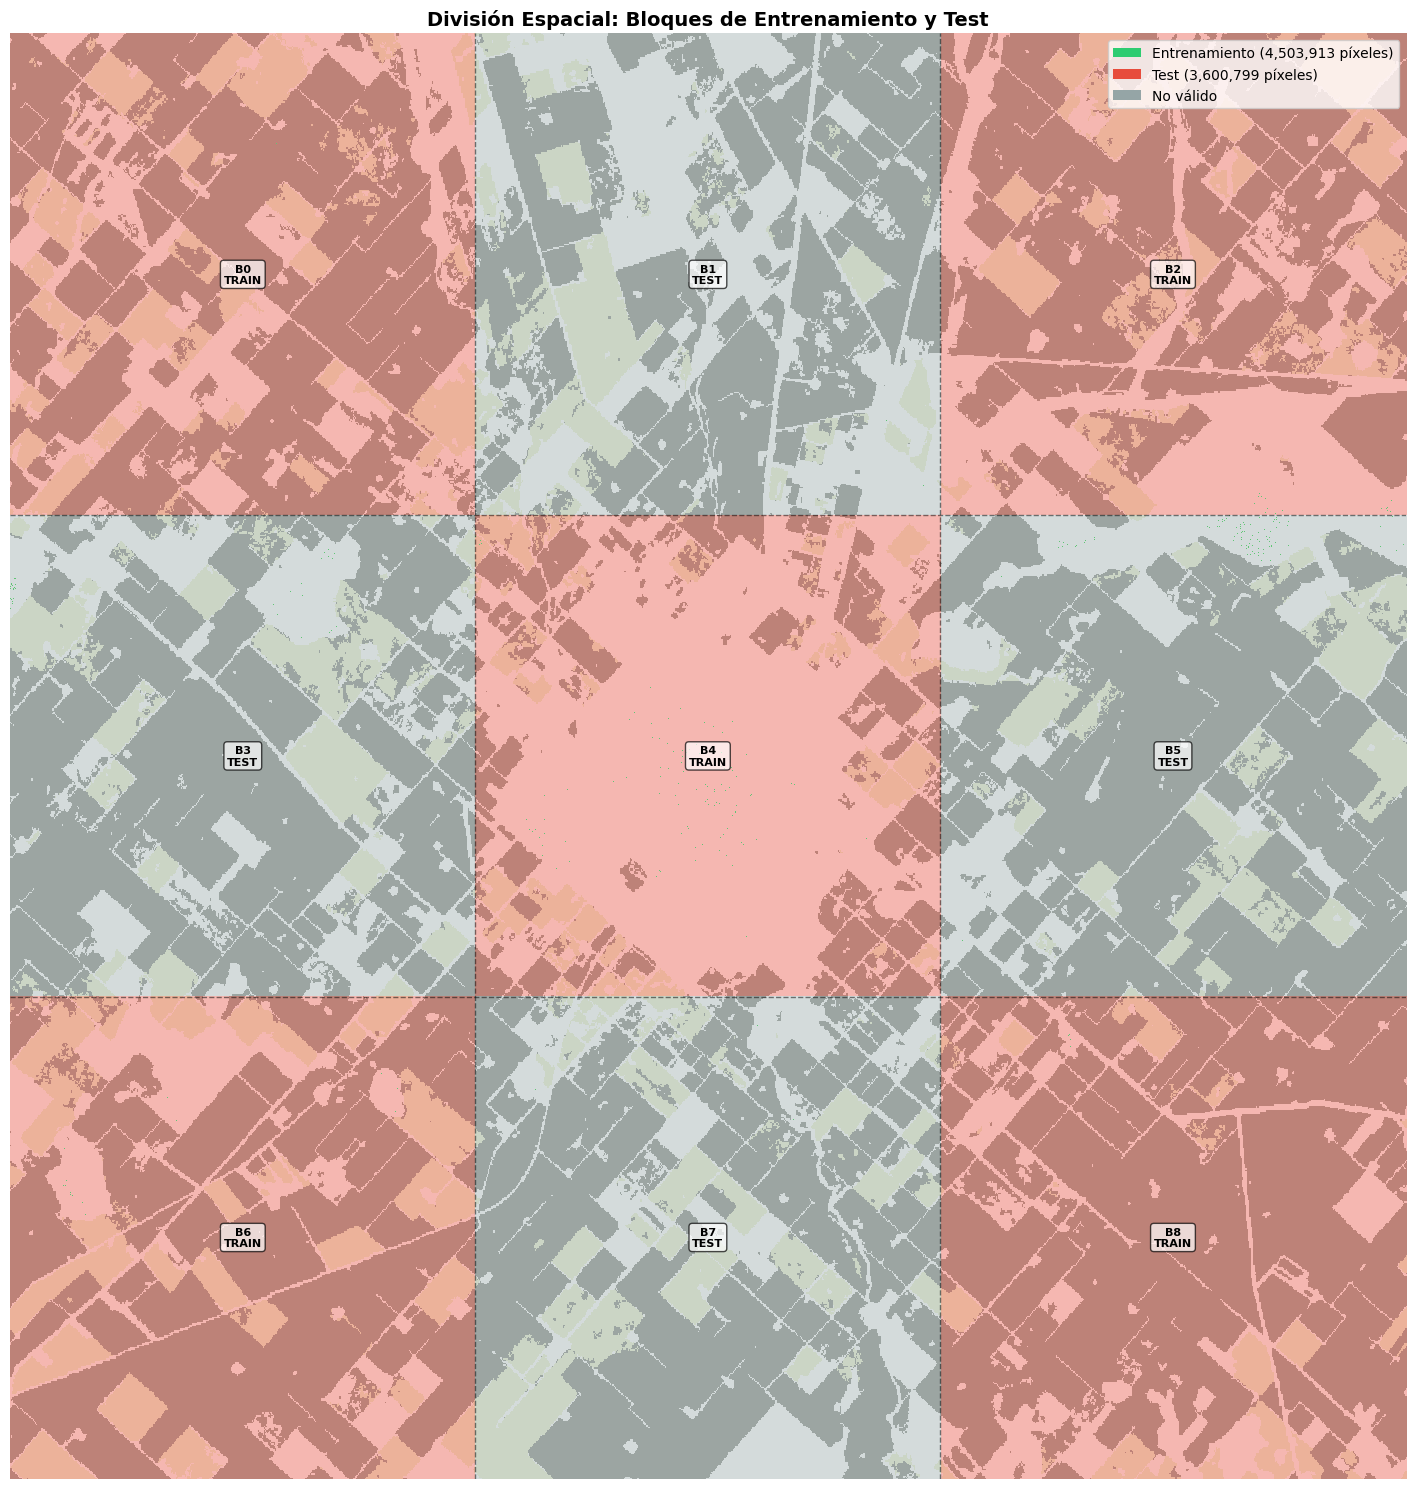


[OK] Visualización de bloques espaciales generada


In [8]:
# Visualizar división espacial de bloques
print("=" * 80)
print("VISUALIZACION DE BLOQUES ESPACIALES")
print("=" * 80)

# Crear mapa de división train/test
mapa_division = np.full((height, width), -1, dtype=np.int32)  # -1 = no válido

# Asignar valores: 0 = train, 1 = test
mapa_division.flat[indices_clean[train_indices]] = 0
mapa_division.flat[indices_clean[test_indices]] = 1

# Crear mapa de fondo con categorías reales para contexto
mapa_fondo = np.full((height, width), -1, dtype=np.int32)
mapa_fondo.flat[indices_clean] = y_clean

# Crear visualización
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Primero mostrar el fondo con las categorías reales
colores_categorias = {
    0: '#339820',  # Verde para CULTIVO AGRÍCOLA
    1: '#646b63',  # Gris para BARBECHO
    2: '#e6f0c2'   # Beige para NO AGRÍCOLA
}
from matplotlib.colors import ListedColormap
cmap_fondo = ListedColormap([colores_categorias[0], colores_categorias[1], colores_categorias[2], '#ffffff'])
ax.imshow(mapa_fondo, cmap=cmap_fondo, vmin=-1, vmax=2, interpolation='nearest', alpha=0.6)

# Luego mostrar la división con transparencia
colores_division = ['#2ecc71', '#e74c3c', '#95a5a6']  # Verde, Rojo, Gris
cmap_division = ListedColormap(colores_division)
im = ax.imshow(mapa_division, cmap=cmap_division, vmin=-1, vmax=1, interpolation='nearest', alpha=0.4)
ax.set_title('División Espacial: Bloques de Entrenamiento y Test', fontsize=14, fontweight='bold')
ax.axis('off')

# Agregar leyenda
from matplotlib.patches import Patch
handles_division = [
    Patch(facecolor=colores_division[0], label=f'Entrenamiento ({len(train_indices):,} píxeles)'),
    Patch(facecolor=colores_division[1], label=f'Test ({len(test_indices):,} píxeles)'),
    Patch(facecolor=colores_division[2], label='No válido')
]
ax.legend(handles=handles_division, loc='upper right', fontsize=10)

# Agregar líneas de división de bloques
for i in range(1, n_bloques_filas):
    y_line = i * tam_bloque_fila
    ax.axhline(y=y_line, color='black', linestyle='--', linewidth=1, alpha=0.5)

for j in range(1, n_bloques_cols):
    x_line = j * tam_bloque_col
    ax.axvline(x=x_line, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Agregar etiquetas de bloques
for bloque_id_num in range(n_bloques_total):
    bloque_fila_idx = bloque_id_num // n_bloques_cols
    bloque_col_idx = bloque_id_num % n_bloques_cols
    
    # Calcular centro del bloque
    centro_y = (bloque_fila_idx + 0.5) * tam_bloque_fila
    centro_x = (bloque_col_idx + 0.5) * tam_bloque_col
    
    # Determinar si es train o test
    es_train_bloque = (bloque_fila_idx + bloque_col_idx) % 2 == 0
    tipo = "TRAIN" if es_train_bloque else "TEST"
    
    # Agregar texto
    ax.text(centro_x, centro_y, f'B{bloque_id_num}\n{tipo}', 
           ha='center', va='center', fontsize=8, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n[OK] Visualización de bloques espaciales generada")


## Entrenamiento del Modelo


ANALISIS DE OOB ERROR vs n_estimators

Evaluando 20 valores de n_estimators...
Rango: 10 a 200 (paso 10)


Entrenando modelos:   0%|          | 0/20 [00:00<?, ?it/s]e:\ade_modelo_agricola\venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
Entrenando modelos:   5%|▌         | 1/20 [00:46<14:34, 46.03s/it]

  n_estimators= 10: OOB error=0.0955 | Tiempo=46.0s | ETA=14.6 min


e:\ade_modelo_agricola\venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
Entrenando modelos:  10%|█         | 2/20 [02:10<20:37, 68.74s/it]

  n_estimators= 20: OOB error=0.0864 | Tiempo=84.6s | ETA=19.6 min


e:\ade_modelo_agricola\venv\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
Entrenando modelos:  15%|█▌        | 3/20 [04:14<26:36, 93.92s/it]

  n_estimators= 30: OOB error=0.0850 | Tiempo=123.9s | ETA=24.0 min


Entrenando modelos:  20%|██        | 4/20 [07:02<32:51, 123.21s/it]

  n_estimators= 40: OOB error=0.0844 | Tiempo=168.1s | ETA=28.2 min


Entrenando modelos:  25%|██▌       | 5/20 [10:25<38:01, 152.07s/it]

  n_estimators= 50: OOB error=0.0840 | Tiempo=203.3s | ETA=31.3 min


Entrenando modelos:  30%|███       | 6/20 [14:15<41:38, 178.48s/it]

  n_estimators= 60: OOB error=0.0837 | Tiempo=229.7s | ETA=33.3 min


Entrenando modelos:  35%|███▌      | 7/20 [18:49<45:25, 209.62s/it]

  n_estimators= 70: OOB error=0.0835 | Tiempo=273.7s | ETA=35.0 min


Entrenando modelos:  40%|████      | 8/20 [24:08<48:52, 244.37s/it]

  n_estimators= 80: OOB error=0.0835 | Tiempo=318.8s | ETA=36.2 min


Entrenando modelos:  45%|████▌     | 9/20 [29:57<50:49, 277.19s/it]

  n_estimators= 90: OOB error=0.0834 | Tiempo=349.4s | ETA=36.6 min


Entrenando modelos:  50%|█████     | 10/20 [36:30<52:08, 312.89s/it]

  n_estimators=100: OOB error=0.0833 | Tiempo=392.8s | ETA=36.5 min


Entrenando modelos:  55%|█████▌    | 11/20 [43:44<52:30, 350.03s/it]

  n_estimators=110: OOB error=0.0832 | Tiempo=434.2s | ETA=35.8 min


Entrenando modelos:  60%|██████    | 12/20 [51:22<51:02, 382.76s/it]

  n_estimators=120: OOB error=0.0831 | Tiempo=457.6s | ETA=34.2 min


Entrenando modelos:  65%|██████▌   | 13/20 [59:41<48:46, 418.07s/it]

  n_estimators=130: OOB error=0.0831 | Tiempo=499.3s | ETA=32.1 min


Entrenando modelos:  70%|███████   | 14/20 [1:08:39<45:26, 454.42s/it]

  n_estimators=140: OOB error=0.0830 | Tiempo=538.4s | ETA=29.4 min


Entrenando modelos:  75%|███████▌  | 15/20 [1:18:17<40:57, 491.50s/it]

  n_estimators=150: OOB error=0.0830 | Tiempo=577.4s | ETA=26.1 min


Entrenando modelos:  80%|████████  | 16/20 [1:28:34<35:17, 529.34s/it]

  n_estimators=160: OOB error=0.0830 | Tiempo=617.2s | ETA=22.1 min


Entrenando modelos:  85%|████████▌ | 17/20 [1:39:30<28:21, 567.29s/it]

  n_estimators=170: OOB error=0.0829 | Tiempo=655.6s | ETA=17.6 min


Entrenando modelos:  90%|█████████ | 18/20 [1:51:01<20:08, 604.43s/it]

  n_estimators=180: OOB error=0.0829 | Tiempo=690.9s | ETA=12.3 min


Entrenando modelos:  95%|█████████▌| 19/20 [2:03:03<10:40, 640.03s/it]

  n_estimators=190: OOB error=0.0828 | Tiempo=723.0s | ETA=6.5 min


Entrenando modelos: 100%|██████████| 20/20 [2:15:48<00:00, 407.43s/it]

  n_estimators=200: OOB error=0.0828 | Tiempo=764.6s | ETA=0.0 min

[OK] Análisis completado en 135.8 minutos

Generando gráfico de OOB error...


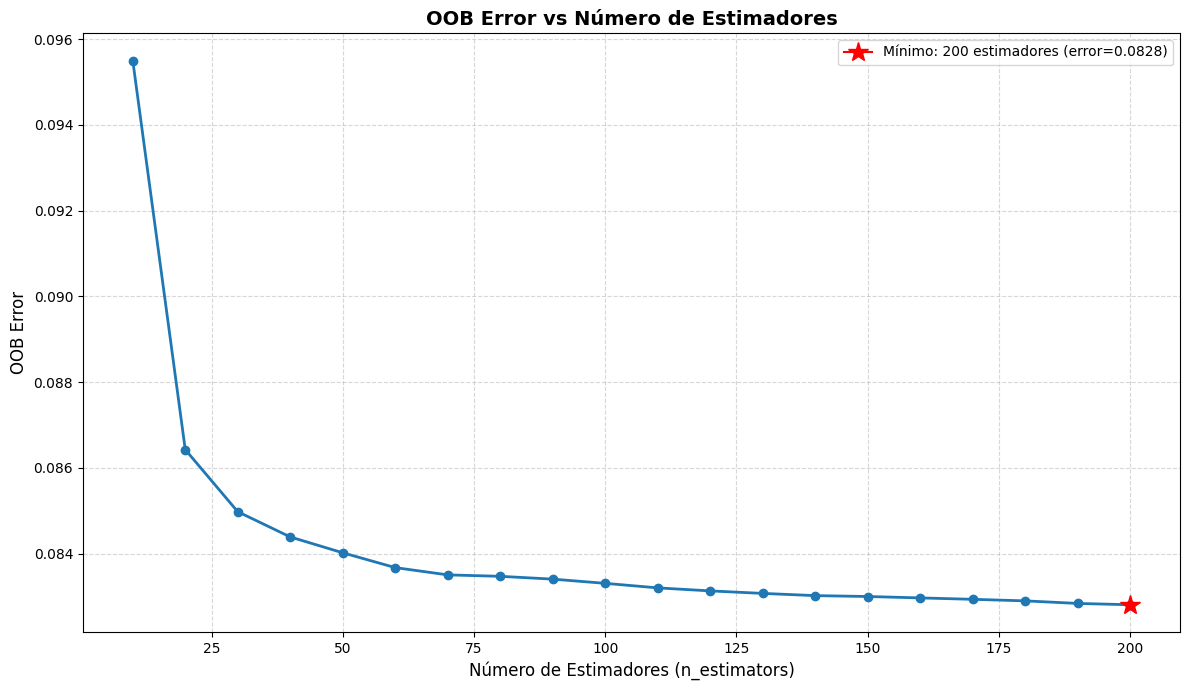


OOB Error mínimo: 0.0828 con 200 estimadores
OOB Error final (200 estimadores): 0.0828

Número óptimo de estimadores seleccionado: 200
  (Error se estabiliza después de 200 estimadores)

ENTRENANDO MODELO FINAL

Entrenando modelo final con n_estimators=200...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 11.4min finished



[OK] Modelo final entrenado en 766.9 segundos
OOB Score del modelo final: 0.9172

Importancia de features (top 5):
  1. NDVI_sd: 0.1505
  2. NDVI_2023-12: 0.1403
  3. NDVI_2024-03: 0.1318
  4. NDVI_2024-02: 0.1295
  5. NDVI_min: 0.1086


In [ ]:
# Análisis de OOB Error vs n_estimators

print("=" * 80)
print("ANALISIS DE OOB ERROR vs n_estimators")
print("=" * 80)

import time
from tqdm import tqdm

# Rango de n_estimators a evaluar
n_estimators_range = range(10, 201, 10)  # 10, 20, 30, ..., 200
oob_errors = []
tiempos_entrenamiento = []

print(f"\nEvaluando {len(n_estimators_range)} valores de n_estimators...")
print(f"Rango: {min(n_estimators_range)} a {max(n_estimators_range)} (paso 10)")

tiempo_inicio_total = time.time()

for n_est in tqdm(n_estimators_range, desc="Entrenando modelos"):
    tiempo_inicio = time.time()
    
    # Entrenar modelo con OOB score habilitado
    rf_temp = RandomForestClassifier(
        n_estimators=n_est,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        oob_score=True,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    rf_temp.fit(X_train, y_train)
    
    # Calcular OOB error (1 - OOB score)
    oob_error = 1 - rf_temp.oob_score_
    oob_errors.append(oob_error)
    
    tiempo_entrenamiento = time.time() - tiempo_inicio
    tiempos_entrenamiento.append(tiempo_entrenamiento)
    
    # Calcular ETA
    tiempo_transcurrido = time.time() - tiempo_inicio_total
    modelos_completados = len(oob_errors)
    modelos_restantes = len(n_estimators_range) - modelos_completados
    
    if modelos_completados > 0:
        tiempo_promedio = tiempo_transcurrido / modelos_completados
        eta_segundos = tiempo_promedio * modelos_restantes
        eta_minutos = eta_segundos / 60
        
        print(f"  n_estimators={n_est:3d}: OOB error={oob_error:.4f} | "
              f"Tiempo={tiempo_entrenamiento:.1f}s | ETA={eta_minutos:.1f} min")

tiempo_total = time.time() - tiempo_inicio_total
print(f"\n[OK] Análisis completado en {tiempo_total/60:.1f} minutos")

# Graficar OOB error vs n_estimators
print("\nGenerando gráfico de OOB error...")
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

ax.plot(list(n_estimators_range), oob_errors, marker='o', linewidth=2, markersize=6)
ax.set_xlabel('Número de Estimadores (n_estimators)', fontsize=12)
ax.set_ylabel('OOB Error', fontsize=12)
ax.set_title('OOB Error vs Número de Estimadores', fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.5)

# Marcar el mínimo
min_error_idx = np.argmin(oob_errors)
min_n_est = list(n_estimators_range)[min_error_idx]
min_error = oob_errors[min_error_idx]
ax.plot(min_n_est, min_error, marker='*', markersize=15, color='red', label=f'Mínimo: {min_n_est} estimadores (error={min_error:.4f})')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nOOB Error mínimo: {min_error:.4f} con {min_n_est} estimadores")
print(f"OOB Error final (200 estimadores): {oob_errors[-1]:.4f}")

In [3]:
# Entrenar y guardar modelo con 50 estimadores
print("\n" + "=" * 80)
print("ENTRENANDO Y GUARDANDO MODELO CON 50 ESTIMADORES")
print("=" * 80)

n_estimators_50 = 50
print(f"\nEntrenando modelo con n_estimators={n_estimators_50}...")
tiempo_inicio_50 = time.time()

rf_model_50 = RandomForestClassifier(
    n_estimators=n_estimators_50,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model_50.fit(X_train, y_train)

tiempo_50 = time.time() - tiempo_inicio_50
print(f"\n[OK] Modelo con 50 estimadores entrenado en {tiempo_50:.1f} segundos")
print(f"OOB Score: {rf_model_50.oob_score_:.4f}")

# Guardar modelo
import joblib
modelo_path_50 = os.path.join(DATA_PROC_DIR, "11_rf_model_50_estimators.pkl")
print(f"\nGuardando modelo en: {modelo_path_50}")

joblib.dump(rf_model_50, modelo_path_50)
print(f"[OK] Modelo guardado exitosamente")

# Importancia de features
importancia_features = rf_model_50.feature_importances_
nombres_features = [
    'NDVI_mediana', 'NDVI_min', 'NDVI_max', 'NDVI_sd',
    'NDVI_2023-12', 'NDVI_2024-01', 'NDVI_2024-02', 'NDVI_2024-03',
    'NDVI_2024-04', 'NDVI_2024-05', 'NDVI_2024-06'
]

print("\nImportancia de features (top 5):")
indices_ordenados = np.argsort(importancia_features)[::-1]
for i, idx in enumerate(indices_ordenados[:5]):
    print(f"  {i+1}. {nombres_features[idx]}: {importancia_features[idx]:.4f}")



ENTRENANDO Y GUARDANDO MODELO CON 50 ESTIMADORES

Entrenando modelo con n_estimators=50...


NameError: name 'X_train' is not defined

## Evaluación del Modelo

Evaluamos el modelo en el conjunto de test usando métricas estándar de clasificación:
- **Accuracy**: Precisión general
- **Precision, Recall**: Por clase
- **Matriz de confusión**: Visualización de errores


In [9]:
# Evaluar modelo
print("=" * 80)
print("EVALUACION DEL MODELO")
print("=" * 80)

# Predicciones
print("\nGenerando predicciones en conjunto de test...")
tiempo_inicio_pred = time.time()

print("  Prediciendo clases...")
y_pred = rf_model_50.predict(X_test)

tiempo_pred = time.time() - tiempo_inicio_pred
print(f"  [OK] Predicciones completadas en {tiempo_pred:.1f} segundos")

print("  Calculando probabilidades...")
tiempo_inicio_proba = time.time()
y_pred_proba = rf_model_50.predict_proba(X_test)
tiempo_proba = time.time() - tiempo_inicio_proba
print(f"  [OK] Probabilidades calculadas en {tiempo_proba:.1f} segundos")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print("\n" + "=" * 80)
print("REPORTE DE CLASIFICACION")
print("=" * 80)
print(classification_report(y_test, y_pred, target_names=nombres_clases, digits=4))

# Matriz de confusión
print("\n" + "=" * 80)
print("MATRIZ DE CONFUSION")
print("=" * 80)
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión (filas=real, columnas=predicho):")
print("                    CULTIVO  BARBECHO  NO_AGRICOLA")
for i, nombre in enumerate(nombres_clases):
    print(f"{nombre:20s} {cm[i, 0]:8d} {cm[i, 1]:8d} {cm[i, 2]:8d}")

# Calcular métricas por clase
print("\nMétricas por clase:")
for i, nombre in enumerate(nombres_clases):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{nombre}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")


EVALUACION DEL MODELO

Generando predicciones en conjunto de test...
  Prediciendo clases...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    3.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


  [OK] Predicciones completadas en 3.8 segundos
  Calculando probabilidades...


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    3.5s finished


  [OK] Probabilidades calculadas en 3.6 segundos

Accuracy: 0.8627 (86.27%)

REPORTE DE CLASIFICACION
                  precision    recall  f1-score   support

CULTIVO AGRÍCOLA     0.9021    0.9050    0.9035   2111656
        BARBECHO     0.7932    0.8889    0.8384    524414
     NO AGRÍCOLA     0.8151    0.7560    0.7844    964729

        accuracy                         0.8627   3600799
       macro avg     0.8368    0.8500    0.8421   3600799
    weighted avg     0.8629    0.8627    0.8621   3600799


MATRIZ DE CONFUSION

Matriz de confusión (filas=real, columnas=predicho):
                    CULTIVO  BARBECHO  NO_AGRICOLA
CULTIVO AGRÍCOLA      1910968    73106   127582
BARBECHO                20415   466177    37822
NO AGRÍCOLA            187002    48405   729322

Métricas por clase:

CULTIVO AGRÍCOLA:
  Precision: 0.9021
  Recall: 0.9050
  F1-score: 0.9035

BARBECHO:
  Precision: 0.7932
  Recall: 0.8889
  F1-score: 0.8384

NO AGRÍCOLA:
  Precision: 0.8151
  Recall: 0.7560
  F1-

## Visualización: Realidad vs Predicción

Generamos mapas comparativos que muestran:
1. **Realidad (INTA)**: Categorías originales del INTA agrupadas
2. **Predicción del modelo**: Clasificación realizada por el Random Forest

Esto permite evaluar visualmente el rendimiento del modelo y detectar patrones de error.


In [17]:
# Crear mapas de realidad vs predicción
print("=" * 80)
print("GENERANDO MAPAS DE COMPARACION")
print("=" * 80)

# Reconstruir mapas completos
mapa_realidad = np.full((height, width), -1, dtype=np.int32)
mapa_prediccion = np.full((height, width), -1, dtype=np.int32)

# Llenar con valores reales
mapa_realidad.flat[indices_clean] = y_clean

# Predecir para todos los píxeles válidos
print("\nPrediciendo para todos los píxeles válidos...")
tiempo_inicio_pred_all = time.time()
n_pixeles_total = len(X_clean)
print(f"  Total de píxeles a predecir: {n_pixeles_total:,}")

# Estimar tiempo basado en predicción anterior
if 'tiempo_pred' in locals() and len(X_test) > 0:
    tiempo_por_pixel = tiempo_pred / len(X_test)
    eta_pred_all = (tiempo_por_pixel * n_pixeles_total) / 60
    print(f"  Tiempo estimado: ~{eta_pred_all:.1f} minutos")

y_pred_all = rf_model_50.predict(X_clean)
tiempo_pred_all = time.time() - tiempo_inicio_pred_all
print(f"  [OK] Predicciones completadas en {tiempo_pred_all:.1f} segundos ({tiempo_pred_all/60:.1f} minutos)")

mapa_prediccion.flat[indices_clean] = y_pred_all

# Crear visualización
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Colores para las clases
colores_clases = {
    0: '#339820',  # Verde para CULTIVO AGRÍCOLA
    1: '#646b63',  # Gris para BARBECHO
    2: '#e6f0c2'   # Beige para NO AGRÍCOLA
}

from matplotlib.colors import ListedColormap
cmap_custom = ListedColormap([colores_clases[0], colores_clases[1], colores_clases[2]])

# Mapa de realidad
ax1 = axes[0]
im1 = ax1.imshow(mapa_realidad, cmap=cmap_custom, vmin=0, vmax=2, interpolation='nearest')
ax1.set_title('Realidad (INTA Verano)', fontsize=14, fontweight='bold')
ax1.axis('off')

# Agregar leyenda
from matplotlib.patches import Patch
handles = [Patch(facecolor=colores_clases[i], label=nombres_clases[i]) for i in range(3)]
ax1.legend(handles=handles, loc='upper right', fontsize=10)

# Mapa de predicción
ax2 = axes[1]
im2 = ax2.imshow(mapa_prediccion, cmap=cmap_custom, vmin=0, vmax=2, interpolation='nearest')
ax2.set_title('Predicción (Random Forest)', fontsize=14, fontweight='bold')
ax2.axis('off')
ax2.legend(handles=handles, loc='upper right', fontsize=10)

plt.suptitle('Comparación: Realidad vs Predicción - Random Forest por Píxel', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Calcular accuracy por región (solo donde hay datos válidos)
mask_comparacion = mapa_realidad >= 0
aciertos = (mapa_realidad[mask_comparacion] == mapa_prediccion[mask_comparacion]).sum()
total_comparacion = mask_comparacion.sum()
accuracy_espacial = aciertos / total_comparacion

print(f"\nAccuracy espacial (sobre mapa completo): {accuracy_espacial:.4f} ({accuracy_espacial*100:.2f}%)")
print(f"Píxeles correctos: {aciertos:,} de {total_comparacion:,}")

# Guardar mapa de predicción como raster
output_pred_path = os.path.join(DATA_PROC_DIR, "11_prediccion_rf_verano.tif")
print(f"\nGuardando mapa de predicción en: {output_pred_path}")

with rasterio.open(RASTER_PATH) as src:
    meta = src.meta.copy()
    meta.update({
        'count': 1,
        'dtype': 'int32',
        'nodata': -1
    })
    
    with rasterio.open(output_pred_path, 'w', **meta) as dst:
        dst.write(mapa_prediccion, 1)
        dst.set_band_description(1, 'Prediccion_RF_Verano')

print("[OK] Mapa de predicción guardado")


GENERANDO MAPAS DE COMPARACION


TypeError: 'float' object cannot be interpreted as an integer

MATRIZ DE CONFUSION NORMALIZADA


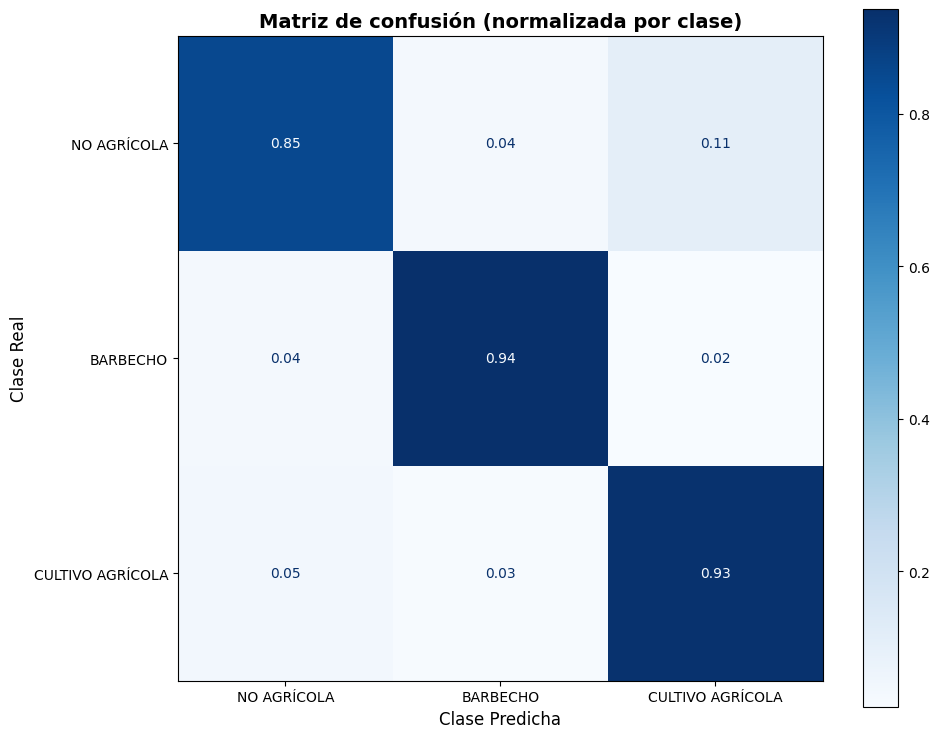


[OK] Matriz de confusión normalizada generada

Valores de la matriz (normalizada por fila):
                    NO AGRÍCOLA  BARBECHO  CULTIVO AGRÍCOLA
NO AGRÍCOLA                 0.85      0.04              0.11
BARBECHO                    0.04      0.94              0.02
CULTIVO AGRÍCOLA            0.05      0.03              0.93


In [11]:
# ============================================================================
# MATRIZ DE CONFUSION NORMALIZADA
# ============================================================================

print("=" * 80)
print("MATRIZ DE CONFUSION NORMALIZADA")
print("=" * 80)

# Preparar vectores 1D: usar todos los datos válidos (train + test)
y_true = y_clean.copy()
y_pred = y_pred_all.copy()

# Verificar que existan los mapas 2D, si no crearlos
if 'mapa_realidad' not in locals() or 'mapa_prediccion' not in locals():
    # Crear mapas 2D a partir de los vectores
    y_true_map = np.full((height, width), -1, dtype=np.int32)
    y_pred_map = np.full((height, width), -1, dtype=np.int32)
    
    # Llenar con valores
    y_true_map.flat[indices_clean] = y_true
    y_pred_map.flat[indices_clean] = y_pred
else:
    # Usar los mapas existentes
    y_true_map = mapa_realidad.copy()
    y_pred_map = mapa_prediccion.copy()

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Normalizar por fila (recall por clase)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Nombres de clases según el mapeo del código:
# 0 = CULTIVO AGRÍCOLA, 1 = BARBECHO, 2 = NO AGRÍCOLA
# Pero el usuario quiere visualizar en orden: NO AGRÍCOLA, BARBECHO, CULTIVO AGRÍCOLA
# Reordenar matriz: índices [2, 1, 0] corresponden a [NO AGRÍCOLA, BARBECHO, CULTIVO AGRÍCOLA]
indices_reordenados = [2, 1, 0]
cm_normalized_reordenada = cm_normalized[np.ix_(indices_reordenados, indices_reordenados)]
nombres_clases = ["NO AGRÍCOLA", "BARBECHO", "CULTIVO AGRÍCOLA"]

# Crear visualización
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Usar ConfusionMatrixDisplay para mejor visualización
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized_reordenada, display_labels=nombres_clases)
disp.plot(ax=ax, values_format='.2f', cmap='Blues')

ax.set_title('Matriz de confusión (normalizada por clase)', fontsize=14, fontweight='bold')
ax.set_xlabel('Clase Predicha', fontsize=12)
ax.set_ylabel('Clase Real', fontsize=12)

plt.tight_layout()
plt.show()

print("\n[OK] Matriz de confusión normalizada generada")
print(f"\nValores de la matriz (normalizada por fila):")
print("                    NO AGRÍCOLA  BARBECHO  CULTIVO AGRÍCOLA")
for i, nombre in enumerate(nombres_clases):
    print(f"{nombre:20s} {cm_normalized_reordenada[i, 0]:11.2f} {cm_normalized_reordenada[i, 1]:9.2f} {cm_normalized_reordenada[i, 2]:17.2f}")


In [15]:
# ============================================================================
# MAPA DE ERRORES
# ============================================================================

print("=" * 80)
print("MAPA DE ERRORES")
print("=" * 80)

# Asegurar que existan los mapas 2D
if 'y_true_map' not in locals() or 'y_pred_map' not in locals():
    # Crear mapas 2D a partir de los vectores
    y_true_map = np.full((height, width), -1, dtype=np.int32)
    y_pred_map = np.full((height, width), -1, dtype=np.int32)
    
    # Llenar con valores
    y_true_map.flat[indices_clean] = y_true
    y_pred_map.flat[indices_clean] = y_pred

# Crear mapa de errores con códigos diferenciados por tipo de error
# Códigos: 
# -1 = no válido
# 0 = acierto (y_pred_map == y_true_map)
# 1 = CULTIVO AGRÍCOLA predicho como BARBECHO
# 2 = CULTIVO AGRÍCOLA predicho como NO AGRÍCOLA
# 3 = BARBECHO predicho como CULTIVO AGRÍCOLA
# 4 = BARBECHO predicho como NO AGRÍCOLA
# 5 = NO AGRÍCOLA predicho como CULTIVO AGRÍCOLA
# 6 = NO AGRÍCOLA predicho como BARBECHO
# Usar las dimensiones de y_true_map para asegurar compatibilidad
error_map = np.full_like(y_true_map, -1, dtype=np.int32)

# Solo comparar donde hay datos válidos
mask_valido_map = (y_true_map >= 0) & (y_pred_map >= 0)

# Crear máscaras para cada clase real
mask_cultivo = (y_true_map == 0) & mask_valido_map
mask_barbecho = (y_true_map == 1) & mask_valido_map
mask_no_agricola = (y_true_map == 2) & mask_valido_map

# Aciertos (todas las clases)
error_map[mask_valido_map & (y_pred_map == y_true_map)] = 0

# Errores: CULTIVO AGRÍCOLA mal clasificado
error_map[mask_cultivo & (y_pred_map == 1)] = 1  # CULTIVO -> BARBECHO
error_map[mask_cultivo & (y_pred_map == 2)] = 2  # CULTIVO -> NO AGRÍCOLA

# Errores: BARBECHO mal clasificado
error_map[mask_barbecho & (y_pred_map == 0)] = 3  # BARBECHO -> CULTIVO
error_map[mask_barbecho & (y_pred_map == 2)] = 4  # BARBECHO -> NO AGRÍCOLA

# Errores: NO AGRÍCOLA mal clasificado
error_map[mask_no_agricola & (y_pred_map == 0)] = 5  # NO AGRÍCOLA -> CULTIVO
error_map[mask_no_agricola & (y_pred_map == 1)] = 6  # NO AGRÍCOLA -> BARBECHO

# Calcular estadísticas
n_aciertos = (error_map[mask_valido_map] == 0).sum()
n_errores = (error_map[mask_valido_map] > 0).sum()
n_total = mask_valido_map.sum()
accuracy_map = n_aciertos / n_total if n_total > 0 else 0

# Estadísticas por tipo de error
n_error_cultivo_barbecho = (error_map == 1).sum()
n_error_cultivo_no_agricola = (error_map == 2).sum()
n_error_barbecho_cultivo = (error_map == 3).sum()
n_error_barbecho_no_agricola = (error_map == 4).sum()
n_error_no_agricola_cultivo = (error_map == 5).sum()
n_error_no_agricola_barbecho = (error_map == 6).sum()

print(f"
Estadísticas del mapa de errores:")
print(f"  Aciertos: {n_aciertos:,} ({100*n_aciertos/n_total:.2f}%)")
print(f"  Errores totales: {n_errores:,} ({100*n_errores/n_total:.2f}%)")
print(f"
  Desglose de errores:")
print(f"    CULTIVO AGRÍCOLA -> BARBECHO: {n_error_cultivo_barbecho:,}")
print(f"    CULTIVO AGRÍCOLA -> NO AGRÍCOLA: {n_error_cultivo_no_agricola:,}")
print(f"    BARBECHO -> CULTIVO AGRÍCOLA: {n_error_barbecho_cultivo:,}")
print(f"    BARBECHO -> NO AGRÍCOLA: {n_error_barbecho_no_agricola:,}")
print(f"    NO AGRÍCOLA -> CULTIVO AGRÍCOLA: {n_error_no_agricola_cultivo:,}")
print(f"    NO AGRÍCOLA -> BARBECHO: {n_error_no_agricola_barbecho:,}")
print(f"  Total: {n_total:,}")

# Crear visualización
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# Colormap con colores distintos para cada tipo de error
# Orden: [-1, 0, 1, 2, 3, 4, 5, 6]
# -1: no válido (blanco)
# 0: acierto (verde claro)
# 1: CULTIVO -> BARBECHO (naranja)
# 2: CULTIVO -> NO AGRÍCOLA (amarillo)
# 3: BARBECHO -> CULTIVO (rojo)
# 4: BARBECHO -> NO AGRÍCOLA (rosa)
# 5: NO AGRÍCOLA -> CULTIVO (morado)
# 6: NO AGRÍCOLA -> BARBECHO (azul)
from matplotlib.colors import ListedColormap, BoundaryNorm
colores_errores = [
    '#ffffff',  # -1: No válido (blanco)
    '#d4edda',  # 0: Acierto (verde claro)
    '#ff8c00',  # 1: CULTIVO -> BARBECHO (naranja)
    '#ffd700',  # 2: CULTIVO -> NO AGRÍCOLA (amarillo)
    '#dc3545',  # 3: BARBECHO -> CULTIVO (rojo)
    '#ff69b4',  # 4: BARBECHO -> NO AGRÍCOLA (rosa)
    '#9370db',  # 5: NO AGRÍCOLA -> CULTIVO (morado)
    '#4169e1'   # 6: NO AGRÍCOLA -> BARBECHO (azul)
]
cmap_errores = ListedColormap(colores_errores)

# Usar BoundaryNorm para mapear correctamente los valores
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
norm = BoundaryNorm(bounds, cmap_errores.N)

im = ax.imshow(error_map, cmap=cmap_errores, norm=norm, interpolation='nearest')
ax.set_title('Mapa de errores por tipo', fontsize=14, fontweight='bold')
ax.axis('off')

# Agregar leyenda con todos los tipos
from matplotlib.patches import Patch
handles_errores = [
    Patch(facecolor=colores_errores[1], label=f'Aciertos ({n_aciertos:,})'),
    Patch(facecolor=colores_errores[2], label=f'CULTIVO -> BARBECHO ({n_error_cultivo_barbecho:,})'),
    Patch(facecolor=colores_errores[3], label=f'CULTIVO -> NO AGRÍCOLA ({n_error_cultivo_no_agricola:,})'),
    Patch(facecolor=colores_errores[4], label=f'BARBECHO -> CULTIVO ({n_error_barbecho_cultivo:,})'),
    Patch(facecolor=colores_errores[5], label=f'BARBECHO -> NO AGRÍCOLA ({n_error_barbecho_no_agricola:,})'),
    Patch(facecolor=colores_errores[6], label=f'NO AGRÍCOLA -> CULTIVO ({n_error_no_agricola_cultivo:,})'),
    Patch(facecolor=colores_errores[7], label=f'NO AGRÍCOLA -> BARBECHO ({n_error_no_agricola_barbecho:,})'),
    Patch(facecolor=colores_errores[0], label='No válido')
]
ax.legend(handles=handles_errores, loc='upper right', fontsize=9)'#ffffff', '#d4edda', '#dc3545']  # Blanco, Verde claro, Rojo
cmap_errores = ListedColormap(colores_errores)

# Usar BoundaryNorm para mapear correctamente los valores
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = BoundaryNorm(bounds, cmap_errores.N)

im = ax.imshow(error_map, cmap=cmap_errores, norm=norm, interpolation='nearest')
ax.set_title('Mapa de errores (aciertos vs errores)', fontsize=14, fontweight='bold')
ax.axis('off')

# Agregar leyenda
from matplotlib.patches import Patch
handles_errores = [
    Patch(facecolor=colores_errores[1], label=f'Aciertos ({n_aciertos:,} píxeles)'),
    Patch(facecolor=colores_errores[2], label=f'Errores ({n_errores:,} píxeles)'),
    Patch(facecolor=colores_errores[0], label='No válido')
]
ax.legend(handles=handles_errores, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("\n[OK] Mapa de errores generado")


SyntaxError: unterminated f-string literal (detected at line 69) (3695700335.py, line 69)

COMPARACION DE AREAS POR CLASE

Comparación de áreas por clase:
           clase  area_real  area_predicha
     NO AGRÍCOLA    2484214        2365450
        BARBECHO    1134418        1281667
CULTIVO AGRÍCOLA    4486080        4457595


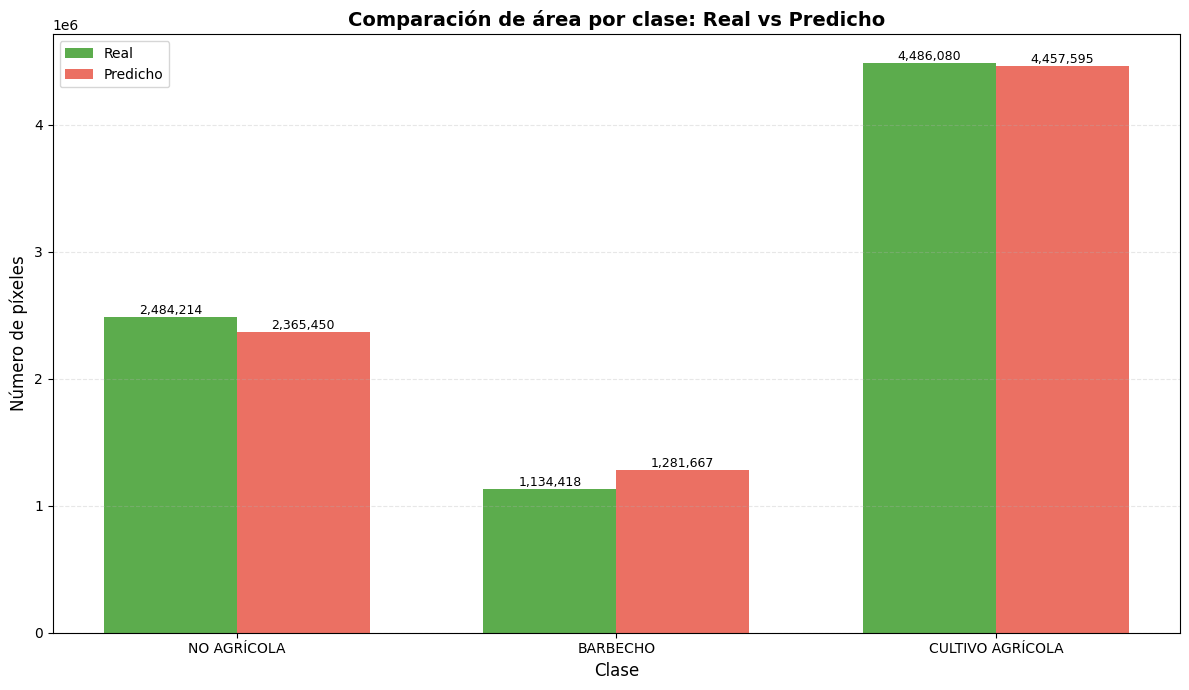


[OK] Comparación de áreas por clase generada


In [16]:
# ============================================================================
# COMPARACION DE AREAS POR CLASE: REAL VS PREDICHO
# ============================================================================

print("=" * 80)
print("COMPARACION DE AREAS POR CLASE")
print("=" * 80)

# Asegurar que existan los vectores 1D
if 'y_true' not in locals():
    y_true = y_clean.copy()
if 'y_pred' not in locals():
    y_pred = y_pred_all.copy()

# Calcular conteos por clase
clases_reales, conteos_reales = np.unique(y_true, return_counts=True)
clases_predichas, conteos_predichas = np.unique(y_pred, return_counts=True)

# Crear diccionarios para facilitar el acceso
dict_real = dict(zip(clases_reales, conteos_reales))
dict_pred = dict(zip(clases_predichas, conteos_predichas))

# Mapeo del código: 0=CULTIVO AGRÍCOLA, 1=BARBECHO, 2=NO AGRÍCOLA
# Orden de visualización deseado: NO AGRÍCOLA, BARBECHO, CULTIVO AGRÍCOLA
nombres_clases_orden = ["NO AGRÍCOLA", "BARBECHO", "CULTIVO AGRÍCOLA"]
clases_orden = [2, 1, 0]  # Mapeo: clase 2 (NO AGRÍCOLA), clase 1 (BARBECHO), clase 0 (CULTIVO AGRÍCOLA)

# Construir DataFrame
data_comparacion = []
for nombre, clase_idx in zip(nombres_clases_orden, clases_orden):
    area_real = dict_real.get(clase_idx, 0)
    area_predicha = dict_pred.get(clase_idx, 0)
    data_comparacion.append({
        'clase': nombre,
        'area_real': area_real,
        'area_predicha': area_predicha
    })

df_comparacion = pd.DataFrame(data_comparacion)

print("\nComparación de áreas por clase:")
print(df_comparacion.to_string(index=False))

# Crear gráfico de barras agrupadas
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

x = np.arange(len(nombres_clases_orden))
width = 0.35

bars1 = ax.bar(x - width/2, df_comparacion['area_real'], width, label='Real', color='#339820', alpha=0.8)
bars2 = ax.bar(x + width/2, df_comparacion['area_predicha'], width, label='Predicho', color='#e74c3c', alpha=0.8)

ax.set_xlabel('Clase', fontsize=12)
ax.set_ylabel('Número de píxeles', fontsize=12)
ax.set_title('Comparación de área por clase: Real vs Predicho', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(nombres_clases_orden)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.3, axis='y')

# Agregar valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n[OK] Comparación de áreas por clase generada")
